C:\Users\duih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AUC: 0.8627238850823415
              precision    recall  f1-score   support

           0       0.66      0.56      0.61        59
           1       0.83      0.88      0.85       141

    accuracy                           0.79       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.78      0.79      0.78       200



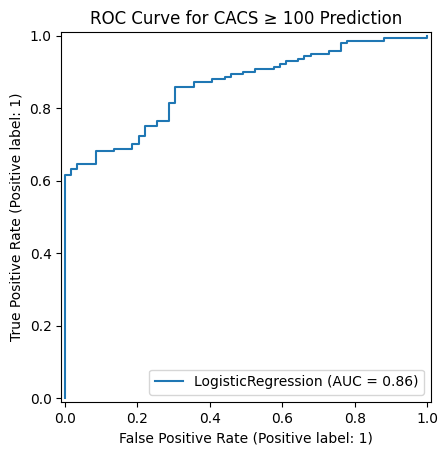

C:\Users\duih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\xgboost\training.py:183: UserWarning: [20:18:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


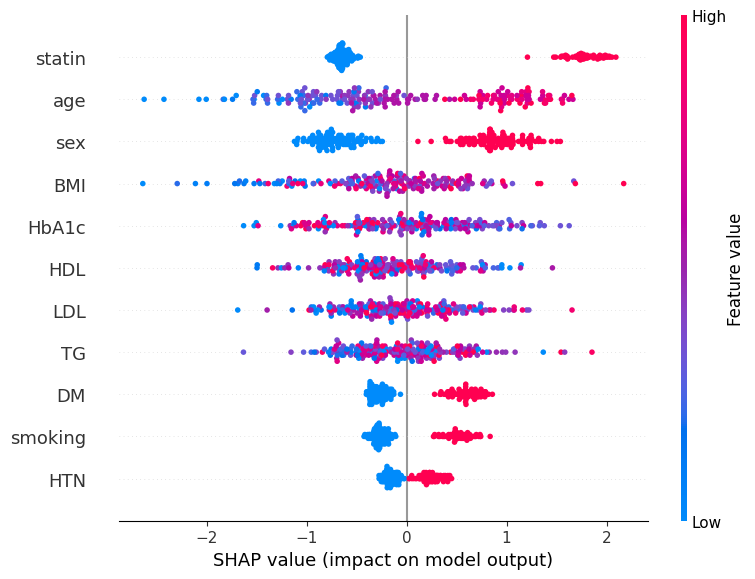

,variable,coefficient,direction,score
0,age,0.211053,+,5
1,sex,0.805204,+,7
2,HTN,0.131642,+,5
3,DM,0.439528,+,7
4,LDL,0.000942,+,1
5,HDL,-0.003163,-,1
6,TG,-0.000096,-,1
7,HbA1c,-0.081050,-,3
8,BMI,0.021064,+,3
9,smoking,1.105240,+,10


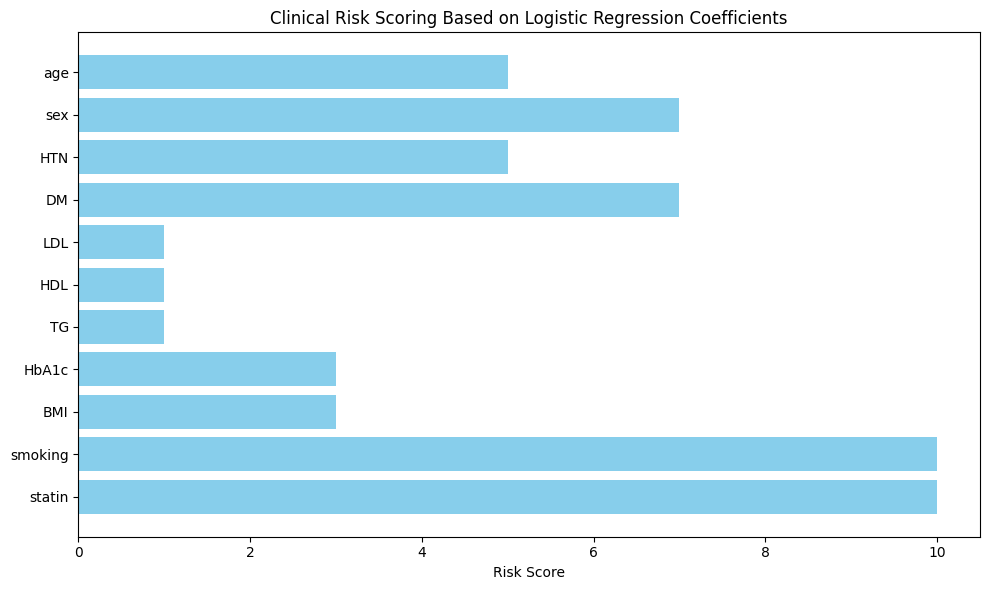

In [1]:
# 📦 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from xgboost import XGBClassifier

# 📂 2. 데이터 불러오기
df = pd.read_csv("CDW_CACS_example_regenerated.csv")  # 경로는 필요 시 수정

# 🎯 3. 피처/타겟 설정
X = df[["age", "sex", "HTN", "DM", "LDL", "HDL", "TG", "HbA1c", "BMI", "smoking", "statin"]]
y = df["CACS_high"]

# ✂️ 4. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📊 5. 로지스틱 회귀 모델 학습 및 평가
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve for CACS ≥ 100 Prediction")
plt.show()

# 📉 6. SHAP 분석 (XGBoost 사용)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

shap.initjs()
shap.summary_plot(shap_values, X_test)  # SHAP 영향도 시각화
shap.force_plot(shap_values[0])         # 첫 번째 환자 예측 설명

# 🧮 7. 리스크 점수 시스템 생성
coef_df = pd.DataFrame({
    "variable": X.columns,
    "coefficient": model.coef_[0]
})
coef_df["score"] = pd.qcut(coef_df["coefficient"].abs(), q=5, labels=[1, 3, 5, 7, 10]).astype(int)
coef_df["direction"] = coef_df["coefficient"].apply(lambda x: "+" if x > 0 else "-")
score_table = coef_df[["variable", "coefficient", "direction", "score"]]
display(score_table)

# 📊 8. 리스크 점수 시각화
plt.figure(figsize=(10, 6))
plt.barh(score_table["variable"], score_table["score"], color="skyblue")
plt.xlabel("Risk Score")
plt.title("Clinical Risk Scoring Based on Logistic Regression Coefficients")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
